## Definitions

In [1]:
#matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Add, Input, GlobalAveragePooling2D, Activation
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)
#os.chdir("/content/gdrive/My Drive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



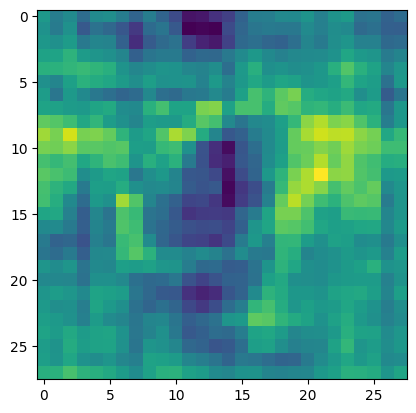

Class: 9

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [2]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 3000
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [3]:
model_name='CNN_4' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.keras'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 10 # batch size
val_split = 0.2 # percentage of samples used for validation (e.g. 0.5)
ep = 20 # number of epochs

In [4]:
def residual_block(x, filters):
    # Shortcut path
    shortcut = Conv2D(filters, (1, 1), padding='same')(x)  # Align number of filters

    # Residual path
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut to the residual path
    x = Add()([shortcut, x])
    x = Activation('relu')(x)  # Apply activation after addition
    return x

## ResNet Inspired

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      1,056 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 14, 14,    │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 14, 14,    │          0 │ add_1[0][0]     

 Total params: 78,826 (307.91 KB)

 Trainable params: 78,442 (306.41 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
4797/4800 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4397 - loss: 1.5861
Epoch 1: val_loss improved from inf to 0.85781, saving model to ./weights/weights_CNN_4.keras
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - accuracy: 0.4399 - loss: 1.5857 - val_accuracy: 0.6916 - val_loss: 0.8578
Epoch 2/20
4797/4800 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7741 - loss: 0.6766
Epoch 2: val_loss improved from 0.85781 to 0.56149, saving model to ./weights/weights_CNN_4.keras
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 84s 18ms/step - accuracy: 0.7741 - loss: 0.6766 - val_accuracy: 0.8138 - val_loss: 0.5615
Epoch 3/20
4798/4800 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8220 - loss: 0.5404
Epoch 3: val_loss did not improve from 0.56149
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.8220 - loss: 0.5404 - val_accuracy: 0.7953 - val_loss: 0.5933
Epoch 4/20
4798/4800 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8387 - loss: 0.4858
Epoch 4: val_loss improved from 0.56149 to

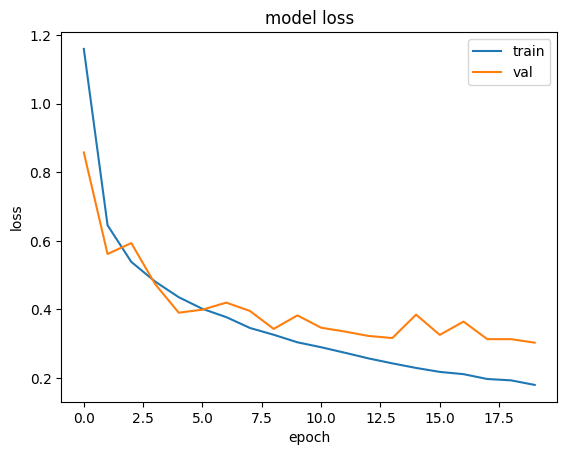

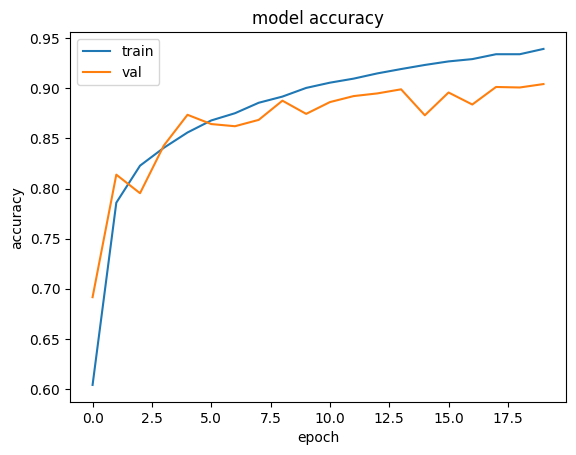

In [5]:
# Input Layer
input_layer = Input(shape=(28, 28, 1))

# Convolutional Layers with Residual Blocks
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = residual_block(x, 32)  # First residual block
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, 64)  # Second residual block
x = GlobalAveragePooling2D()(x)

# Output Layer
output_layer = Dense(num_cls, activation='softmax')(x)

# Define and Compile Model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary and Training
model.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
callbacks_list = [checkpointer]

history = model.fit(x_train, y_train,
                    epochs=ep,
                    batch_size=b_size,
                    verbose=1,
                    shuffle=True,
                    validation_split=val_split,
                    callbacks=callbacks_list)

print('CNN_1 weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Make predictions in test set

In [6]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')

model = load_model(pweight)
y_pred = model.predict(x_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_test is also in class indices (not one-hot encoded)
if len(y_test.shape) > 1:  # If y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

Acc_pred = sum(y_pred_classes == y_test) / len(y_test)
#Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy in test set is: 0.8976
